# Deep Metal
## Putting heavy metal into data science

### Part I - Dataset cleaning and first content analysis

The notebook contains:

- Examples of rows from a cleaned dataset;
- Brief analysis of quantities (amount of artists, albums, album types, songs etc.) and simple statistics;
- Brief analysis about album releases over the years and simple statistics about distribution;
- Statistics about language distribution;
- Bands popularity: statistics about the most represented bands in the dataset in terms of albums and songs;

In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib
import numpy as np
import pandas as pd
import pycountry
import scipy

from IPython.display import display, HTML, Markdown
from common.graphs import plot_pie_graph, plot_vertical_bars, plot_horizontal_bars, printmd

## Dataset

Dataset imported from DarkLyrics.com through the `metalparser` library and cleaned up.
The dataset has been cleaned according to the `clean_dataset.py` script:
- deduplication of songs by same artist and album (happens when the crawler retrieved remasters of the same albums, or live albums);
- songs having no text at all (excluding those labeled as "Instrumental") has been removed;
- album types having similar label has been normalized in a unique corresponding label;
- lyrics has been sanitized (max 2 consecutive newline chars, space trimming, removed tags between squared brackets).

Every row in the dataset corresponds to a song ang contains the following informations:

- Artist;
- Album;
- Album type;
- Release year;
- Song title;
- Track number on the album;
- Lyrics text (where available);
- Info about the language (ISO 639-3 code and name)

In [2]:
dataset_df = pd.read_csv('../datasets/metal_dataset_clean_lang.csv', encoding='utf-8', sep='|')

dataset_df.sample(n=10, random_state=100)

,artist,album,album_type,release_year,title,track_no,lyrics,lang_iso,lang_name
86644,Forevermore,Sojourner,Studio,2012,Artifice,3,Look at me\nI am the quintessential believer\n...,eng,English
162058,Pathology,The Time Of Great Purification,Studio,2012,The Everlasting Plague,13,"2012 The end of days to come,\nThe earth will ...",eng,English
202498,Tarot,For The Glory Of Nothing,Studio,1998,The Scourger,7,I've seen the marvesl of the molten fles\nI've...,eng,English
101225,Helloween,The Time Of The Oath,Studio,1996,Before The War,6,Come take a look up to the constellations\nTak...,eng,English
57348,Death Angel,The Evil Divide,Studio,2016,Hell To Pay,5,"You've gained my trust, and friendship\nAnd th...",eng,English
211680,Tunrida,Era 2001,Studio,2001,Countdown To Doomsday,1,"Ten\n""H"" is the letter\nIt won't get any bette...",eng,English
102178,Hexx,No Escape,Studio,1984,Night Of Pain,6,(oooh… she’s hot!!)\nLast night I was feeling ...,eng,English
63762,Diabolical Breed,Dark Alliance,Demo,2000,Woods Of Thorn,1,Beyond the green woods of elves where the clou...,eng,English
169027,Queensryche,Live Evolution,Studio,2001,The Right Side Of My Mind,30,"Hey, are you okay? Better luck on another day....",eng,English
14428,Anubis Gate,Covered In Black,Studio,2017,Psychotopia,1,I don't believe\nI ordered this kind\nOf evacu...,eng,English


## Quantities: about artists, albums and songs

A brief analysis of dataset contents, reporting information about:

- Amount of artists, albums and songs, with some averages;
- Simple statistics about song types and album types;
- Distribution of the albums over the years, with simple statistics;

In [3]:
songs_number = len(dataset_df)
albums_number = len(np.unique(dataset_df[['artist', 'album']].values))
artists_number = len(dataset_df.artist.unique())

printmd(f"**SONGS:** {songs_number}")
printmd(f"**ALBUMS:** {albums_number}")
printmd(f"**ARTISTS:** {artists_number}")
printmd("---")
printmd(f"**AVERAGE NUMBER OF ALBUMS PER ARTIST:** {round(albums_number / artists_number, 2)}")
printmd(f"**AVERAGE NUMBER OF SONGS PER ALBUM:** {round(songs_number / albums_number, 2)}")
printmd(f"**AVERAGE NUMBER OF SONGS PER ARTIST:** {round(songs_number / artists_number, 2)}")

**SONGS:** 230376

**ALBUMS:** 30730

**ARTISTS:** 8202

---

**AVERAGE NUMBER OF ALBUMS PER ARTIST:** 3.75

**AVERAGE NUMBER OF SONGS PER ALBUM:** 7.5

**AVERAGE NUMBER OF SONGS PER ARTIST:** 28.09

### Song types

,songs_type,count
0,Songs with lyrics,216979
1,Instrumental songs,13397


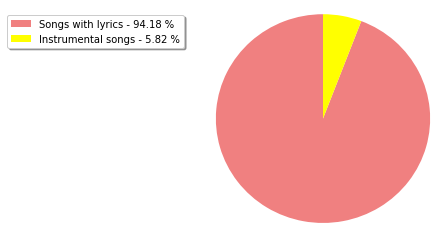

In [4]:
songs_with_lyrics = len(dataset_df.loc[dataset_df["lyrics"] != 'Instrumental', 'lyrics'])
instrumental_songs = len(dataset_df.loc[dataset_df["lyrics"] == 'Instrumental', 'lyrics'])
songs_type_df = pd.DataFrame({
    'songs_type': ['Songs with lyrics', 'Instrumental songs'],
    'count': [songs_with_lyrics, instrumental_songs]
})

display(HTML(songs_type_df.to_html()))

plot_pie_graph(
    x=songs_type_df['songs_type'],
    y=songs_type_df['count'],
    title='Distribution of songs types',
    figsize=(4, 4), 
    labels=list(songs_type_df['songs_type']), 
    labeldistance=0,
    pctdistance=0.5,
    shadow=True
)

### Album types

,album_type,count
0,Studio,213536
1,EP,12729
2,Demo,3958
4,Live,81
3,Compilation,71
5,Collaboration,1


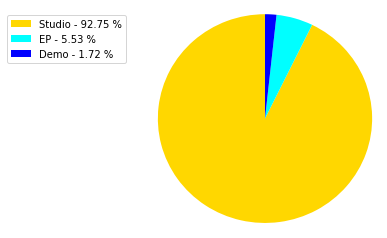

In [5]:
album_type_dist = dataset_df.groupby('album_type', sort=False)['album_type'] \
                       .count().reset_index(name='count').sort_values(['count'], ascending=False)
display(HTML(album_type_dist.to_html()))

plot_pie_graph(
    x=album_type_dist[:3]['album_type'],
    y=album_type_dist[:3]['count'],
    title='Top 3 album type distribution on DarkLyrics.com',
    figsize=(4, 4), 
    labels=list(album_type_dist['album_type']), 
    labeldistance=0,
    pctdistance=0.5
)

## Quantities: about time

Simple statistics about albums distribution over the years:

- Oldest and newest album;
- Most and less prolific 5 years and distribution graph;

### Oldest and newest

In [6]:
release_years = sorted(list(dataset_df.release_year.unique()))
oldest_albums = dataset_df.loc[
    dataset_df["release_year"] == release_years[0], 
    ['release_year', 'artist', 'album', 'album_type']
].reset_index().groupby('album').first().reset_index().drop(columns=['index'])
newest_albums = dataset_df.loc[
    dataset_df["release_year"] == release_years[-1], 
    ['release_year', 'artist', 'album', 'album_type']
].reset_index().groupby('album').first().reset_index().drop(columns=['index'])

printmd(f"**Albums and songs in the dataset has been released through {release_years[-1] - release_years[0]} years ({release_years[0]} - {release_years[-1]})**")
printmd("---")
printmd("**OLDEST ALBUM:**")
display(HTML(oldest_albums.to_html()))
printmd("**NEWEST ALBUM:**")
display(HTML(newest_albums.to_html()))

**Albums and songs in the dataset has been released through 52 years (1968 - 2020)**

---

**OLDEST ALBUM:**

,album,release_year,artist,album_type
0,Vincebus Eruptum,1968,Blue Cheer,Studio


**NEWEST ALBUM:**

,album,release_year,artist,album_type
0,Cosmic Terror,2020,The Spirit,Studio


### Albums distribution over the years

**MOST PROLIFIC 5 YEARS**

,release_year,count
43,2011,1450
44,2012,1304
42,2010,1269
45,2013,1265
37,2005,1214


**LESS PROLIFIC 5 YEARS**

,release_year,count
6,1974,3
2,1970,3
1,1969,2
0,1968,1
52,2020,1


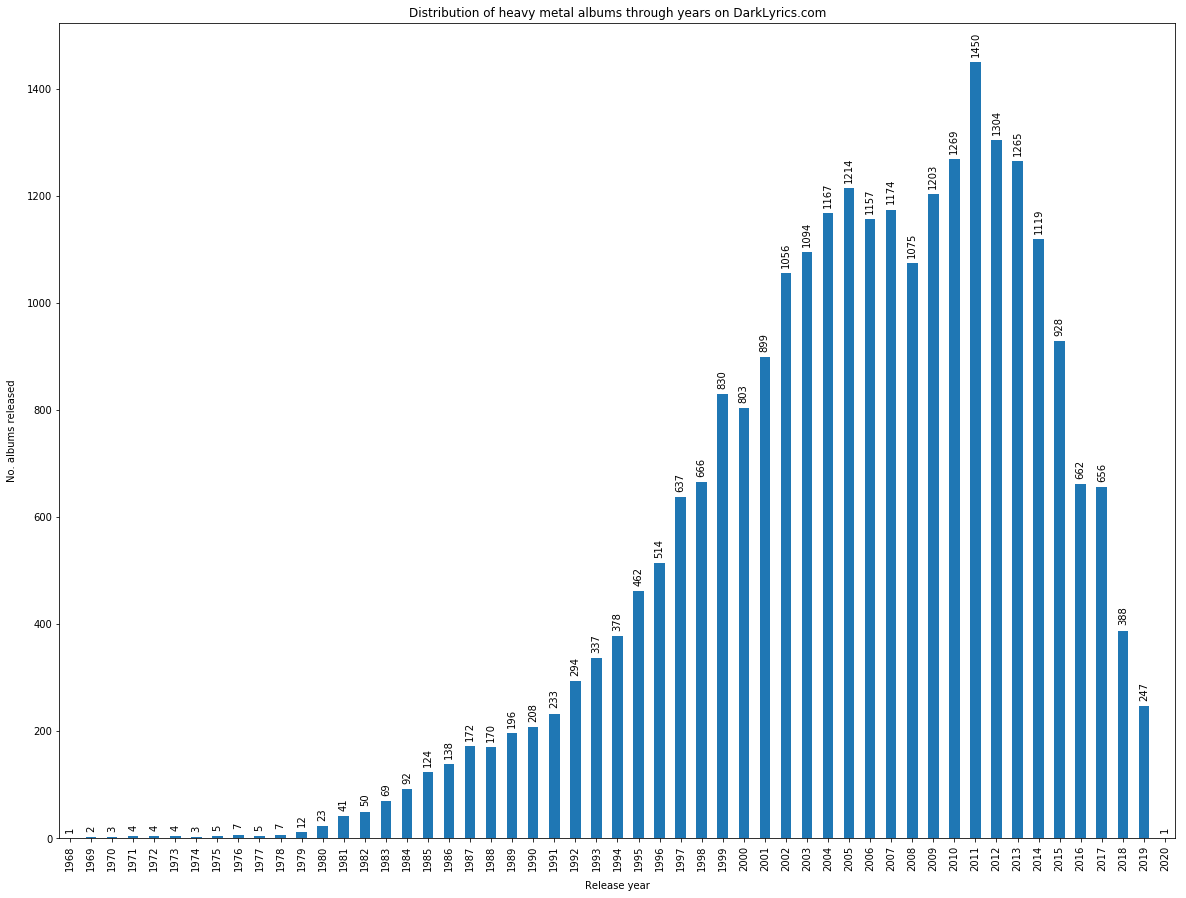

In [7]:
albums_dist = dataset_df.groupby(['release_year', 'album', 'artist', 'album_type']).first().reset_index()
albums_year_dist = albums_dist.groupby('release_year', sort=False)['release_year'].count() \
        .reset_index(name='count').sort_values(['release_year'], ascending=True)


printmd(f'**MOST PROLIFIC 5 YEARS**')
display(HTML(albums_year_dist.sort_values(['count'], ascending=False).head(n=5).to_html()))

printmd(f'**LESS PROLIFIC 5 YEARS**')
display(HTML(albums_year_dist.sort_values(['count'], ascending=False).tail(n=5).to_html()))

plot_vertical_bars(
    albums_year_dist, 
    x='release_year',
    xlabel='Release year',
    y='count',
    ylabel='No. albums released',
    figsize=(20, 15), 
    title='Distribution of heavy metal albums through years on DarkLyrics.com',
    display_values=True
)



## Quantities: about language

Lyrics language distribution on the dataset. Surprisingly, or maybe not, there is also a dead language on the top 20, which is latin. Mostly used for songs with obscure athmospheres (latin lyrics are mostly requiem prayers or invocations to Satan :D )

,lang_iso,lang_name,count
0,eng,English,195156
1,deu,German,5699
2,spa,Spanish,5003
3,fin,Finnish,1806
4,fra,French,1360
5,swe,Swedish,1147
6,nor,Norwegian,954
7,pol,Polish,863
8,rus,Russian,680
9,hun,Hungarian,602


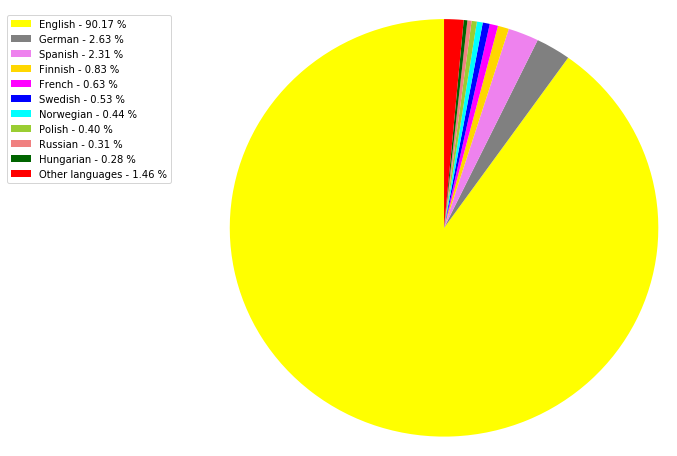

In [8]:
songs_with_defined_lang = dataset_df[dataset_df.lang_iso.str.lower() != 'undefined']
songs_with_undefined_lang = dataset_df[dataset_df.lang_iso.str.lower() == 'undefined']

lang_dist = songs_with_defined_lang.groupby(['lang_iso', 'lang_name'], sort=False)['lang_iso'].count() \
        .reset_index(name='count').sort_values(['count'], ascending=False)

lang_dist_table = lang_dist[:20][['lang_iso', 'lang_name', 'count']].reset_index().drop(columns=['index'])
display(HTML(lang_dist_table.to_html()))


lang_dist_graph = pd.concat([
    lang_dist[:10],
    pd.DataFrame({
        'lang_iso': ['oth'], 
        'lang_name': 'Other languages', 
        'count': lang_dist[11:]['count'].sum()
    })
], ignore_index=True)

plot_pie_graph(
    x=lang_dist_graph['lang_name'],
    y=lang_dist_graph['count'],
    title='Top 10 languages distribution on DarkLyrics.com',
    figsize=(8, 8), 
    labels=list(lang_dist_graph['lang_name']), 
    labeldistance=0,
    pctdistance=10
)


In [9]:
songs_in_latin = dataset_df[dataset_df.lang_iso.str.lower() == 'lat'].sample(n=5, random_state=100)

printmd("**EXAMPLES OF SONGS IN LATIN**")
printmd("---")
display(HTML(songs_in_latin.to_html()))

**EXAMPLES OF SONGS IN LATIN**

---

,artist,album,album_type,release_year,title,track_no,lyrics,lang_iso,lang_name
162632,Penumbra,The Last Bewitchment,Studio,2002,Pie Jesu,9,Pie Jesu domine\nDona eis requiem\nDies irae dies illa\nSolvet saeclum in favilla\nTeste David cum Sybilla\nTuba mirum spargen sonum\nPer sepulcra regionum\nCoget omnes ante thronum\nLiber scriptus proferetur\nIn quo totum continetur\nUnde mundus Judicetur\nRex Tremendae majestetis\nFlammis accribu addictis\nVoca me cum benedictis\nOro supplex et acclinis\nCor contritum quasi cinis\nGere curan mei finis\nLacrimosa dies illa\nQua resurget ex favilla\nJudicandos homo reus\nHuic ergo perce deus\nPie jesu dona eis requiem,lat,Latin
128826,Luca Turilli'S Rhapsody,"Prometheus, Symphonia Ignis Divinus",Studio,2015,Nova Genesis (Ad Splendorem Angeli Triumphantis),1,"""We are not human beings having a spiritual experience.\nWe are spiritual beings having a human experience""\n\n""Exurgat Deus et fiat lux in tenebris\nStellarum Veritas, nova genesis""\n\nVade accipe librum apertum\nDe manu angeli stantis\nSupra mare et supra terram\n\nDeus exurgat\nEt dissipentur inimici ejus\nEt fugiant qui oderunt eum a cacie ejus\nSicut fluit cera a facie ignis\nSic pereant peccatores a facie Dei\n\nDeus exurgat\nEt dissipentur inimici ejus\nEt fugiant qui oderunt eum a cacie ejus\n\nSacra vis, lux in tenebris, nova genesis\nSicut fluit cera a facie ignis\nSic pereant peccatores nunc a facie Dei\n\nAlpha, Alpha et Omega\nFiat lux et tenebra\nSacra vis, nova genesis",lat,Latin
77157,Epica,The Holographic Principle,Studio,2016,Eidola,1,"Idolam kwam creamus alimus, oramus\nFerimur simulacris fictis antiquis et futuris\n\nOmnia solent fieri\nHoc tempore atque nunc et semper\n\nFictie fallimur, non vivimus sine mora\nElimina illecebras fugantes nos\n\nVaca a timore et tempore\n\nAnimam libera nunc\nUt liberes te a tempore et abs timore\nTu solus eo modo facturus et veritatem semper tuam",lat,Latin
31076,Blackmass,Diablical Ritual,Demo,2002,Invocatio Mallum (Call Upon The Evil),1,"Gelida ventus secare intus niger saltus\nAuctus luna refulgere id niger vultus\nSanguis ex donum virgo fervefacere in Ahenum\nEt in ara id summus dominus tenebrae benedicere\n...nobis...\nIn quinque hominis nobis occludere id quinque acuminis\nAc sicut donum virgo juvenil eam Satanas\nNon sine id sanctus pugio ego tolere manus caellum\nAc profere verbum ex odium affinis invocare dei\n...sopire Inferna...\nSatanas, Luciferi, Leviatan ac Belial\nAudire nostrum precum\nNobis invocare prave\nNobis invocare prave\nNobis invocare prave\nNobis invocare ad regnare\nLuciferi archangelux dei Inferni\nNobis tuus suplicare\nNobis tuus ordinare\nQui advenire, qui revocatus\nErga nobis oculus et mostrare tuus horribilis fácies\nAdvenire, venire, ego vocare\nVenire tenebrae Princeps\nRevocatus tuus exercitus, cinis uti is magnum rex\nPenetralium in nostrum animus uti nobis\nTuus glorificare creare nobis corpus\nTuus summus domicilium\nInvocatio erga umbra Dominus\nCall upon the Evil...",lat,Latin
168864,Qntal,Qntal VI: Translucida,Studio,2008,Glacies,6,"Cedit, hiems, tua durities;\nFrigor abit, rigor et glacies\nBrumalis et feritas, rabies,\nTorpor et improba segnities.\n\nVeris adest elegans acies,\nClara nitet sine nube dies,\nNocte micant Pliadum facies;\nGrata datur modo temperies.\n\nEst pura mundi superficies,\nGramine redolent planities,\nInduitur foliis abies,\nPicta canit volucrum series,\nPrata virent, iuvenum requies.\n\nNunc, Amor aureus, advenies,\nIndomitos tibi subicies.\nTendo manus; michi quid facies?\nQuam dederas, rogo, concilies.\n\nEst pura mundi superficies,\nGramine redolent planities,\nInduitur foliis abies,\nPicta canit volucrum series,\nPrata virent, iuvenum requies",lat,Latin


## Quantities: about popularity

Statistics about the most represented bands in the dataset in terms of:

- Quantity of songs per band;
- Quantity of albums per band;

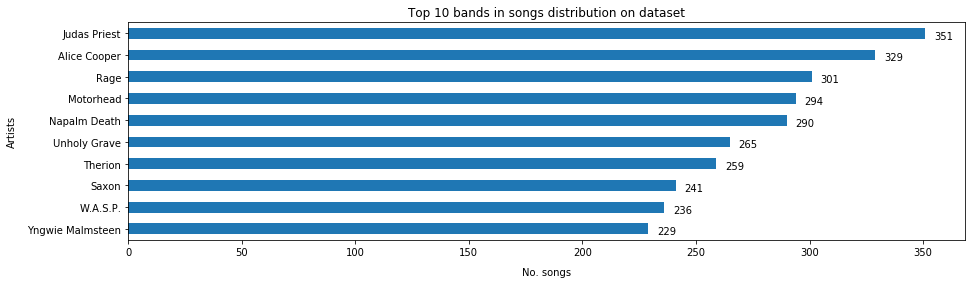

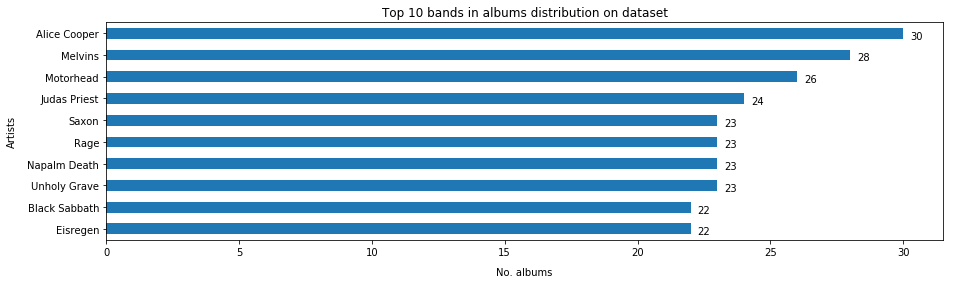

In [10]:
songs_bands_dist = dataset_df.groupby('artist')['artist'].count().reset_index(name='count').sort_values(['count'], ascending=False)

albums_bands_dist = albums_dist.loc[albums_dist["album_type"].str.lower() == 'studio']
albums_bands_dist = albums_dist.groupby(['artist'])['artist'].count().reset_index(name='count').sort_values(['count'], ascending=False)



plot_horizontal_bars(
    songs_bands_dist[:10].sort_values(['count'], ascending=True),
    x='artist',
    xlabel='No. songs',
    y='count',
    ylabel='Artists',
    figsize=(15, 4),
    title='Top 10 bands in songs distribution on dataset',
    values_offset=8
)

plot_horizontal_bars(
    albums_bands_dist[:10].sort_values(['count'], ascending=True),
    x='artist',
    xlabel='No. albums',
    y='count',
    ylabel='Artists',
    figsize=(15, 4),
    title='Top 10 bands in albums distribution on dataset',
    values_offset=.5
)